In [221]:
import numpy as np
import numpy.linalg as nla
import numpy.random as random
import scipy.linalg as la
import scipy.sparse as sp
from matplotlib import pyplot as plt
from itertools import product
import time
from tqdm import tqdm
from IPython.display import clear_output

In [279]:
def random_Cm(N):
    # contruct a random mixed two-point function <c^\dagger c> if specific Cm not given
    D = np.diag(random.uniform(size = N)) # construct a diagonal matrix with random entries between 0 and 1
    # construct random unitary matrices
    Hmatrix = random.normal(size = (N, N)) + 1j*random.normal(size = (N, N)) # construct random square complex matrix
    Hmatrix = (Hmatrix + np.conj(Hmatrix).T)/2 # Hermitize
    Umatrix = la.expm(1j*Hmatrix) # Generate Unitary matrix
    Gamma = Umatrix @ D @ np.conj(Umatrix).T 
    
    return Gamma.reshape(-1, 1, order = 'F') # return vectorized covariance

def chern_insulator_hamiltonian(kx, ky, mu):
    X = np.array([[0,1],[1,0]]) # Pauli X
    Y = 1j*np.array([[0,-1],[1,0]]) # Pauli Y
    Z = np.array([[1,0],[0,-1]]) # Pauli Z
    return np.sin(kx)*X + np.sin(ky)*Y + (mu - np.cos(kx) - np.cos(ky))*Z
#    
#def chern_insulator_eigenstates(k_grid, mu):
#
#    # Initialize arrays to store eigenstates
#    LB_state_list = np.zeros((2, len(k_grid)), dtype=np.complex128)
#    UB_state_list = np.zeros((2, len(k_grid)), dtype=np.complex128)
#
#    # Loop over k-points and compute eigenstates
#    for idx, (kx, ky) in enumerate(k_grid):
#        H = chern_insulator_hamiltonian(kx, ky, mu)
#        _, eigvecs = nla.eigh(H)  # Diagonalize the Hamiltonian
#
#        # Store eigenvectors
#        LB_state_list[:, idx] = eigvecs[:, 0].copy()  # Lower band
#        UB_state_list[:, idx] = eigvecs[:, 1].copy()  # Upper band
#
#    return LB_state_list, UB_state_list

def chern_insulator_eigenstates(k_grid, mu):

    # assuming k_grid = [[kx1, ky1], [kx2, ky1],...,[kxN,ky1], [kx1, ky2],....,.....[kxN,kyN]]

    # Initialize arrays to store eigenstates
    LB_state_list = np.zeros((2, len(k_grid)), dtype=np.complex128)
    UB_state_list = np.zeros((2, len(k_grid)), dtype=np.complex128)

    for idx, (kx, ky) in  enumerate(k_grid):
        dx_k = np.sin(kx)
        dy_k = np.sin(ky)
        dz_k = mu - np.cos(kx) - np.cos(ky)
        
        phi_k = np.atan2(dy_k, dx_k) # polar angle
        theta_k = np.atan2(np.sqrt(dx_k**2 + dy_k**2), dz_k) # azimuthal angle

        sine = np.sin(theta_k/2)*np.exp(-1j*phi_k)
        cosine = np.cos(theta_k/2)

        LB_state_list[:, idx] = np.array([[-np.conj(sine)],[cosine]])
        UB_state_list[:, idx] = np.array([[cosine],[sine]])
    
    return LB_state_list, UB_state_list

def create_k_grid(Lx, Ly):
    # Create list of (kx, ky) tuples where ky varies first
    kx_vals = (2*np.pi/Lx) * np.arange(-Lx/2, Lx/2, 1)
    ky_vals = (2*np.pi/Ly) * np.arange(-Ly/2, Ly/2, 1)
    return np.array(list(product(kx_vals, ky_vals)))

def create_r_grid(Lx, Ly):
    # Create list of (x, y) tuples where y varies first
    x_vals = np.arange(0, Lx, 1)
    y_vals = np.arange(0, Ly, 1)
    return np.array(list(product(x_vals, y_vals)))

# compute real space chern insulator cm
def chern_insulator_Cm(Lx, Ly, mu):

    k_grid = create_k_grid(Lx, Ly)
    r_grid = create_r_grid(Lx, Ly)

    # Fourier Transform Matrix
    F = np.exp(-1j*k_grid @ r_grid.T)/np.sqrt(Lx*Ly)

    # Compute eigenstates of the Chern insulator model
    LB_state_list, _ = chern_insulator_eigenstates(k_grid, mu)

    LB_real_space_state_list = (np.conj(LB_state_list) @ F).reshape(-1, 1, order='F')

    LB_real_space_state_matrix_element = LB_real_space_state_list @ np.conj(LB_real_space_state_list).T
    
    return LB_real_space_state_matrix_element.reshape(-1, 1, order='F')
    
    


In [255]:
# test chern insulator cm
Lx = 2
Ly = 2
mu = 1
Cm = chern_insulator_Cm(Lx, Ly, mu)
gamma = random_Cm(Lx*Ly)
print(Cm)

[[ 0.42885013-8.62583219e-19j]
 [ 0.08705139+3.69024940e-02j]
 [-0.08258683+4.62566375e-02j]
 [ 0.15917086-1.87240333e-02j]
 [ 0.08705139-3.69024940e-02j]
 [ 0.30521037+2.38779938e-18j]
 [ 0.04146882+9.60692092e-03j]
 [ 0.0109147 +8.58661683e-02j]
 [-0.08258683-4.62566375e-02j]
 [ 0.04146882-9.60692092e-03j]
 [ 0.25603815-2.87259026e-18j]
 [-0.07697727+9.79013561e-02j]
 [ 0.15917086+1.87240333e-02j]
 [ 0.0109147 -8.58661683e-02j]
 [-0.07697727-9.79013561e-02j]
 [ 0.3059092 +1.42115058e-18j]]


In [ ]:

def Wannier_function(Lx, Ly, mu, R):
    
    # construct single-particle wannier wavefunction localized at site R, which a np.array of x and y coords

    # Define trial wavefunctions
    trial_A = np.array([[1], [0]])
    trial_B = np.array([[0], [1]])

    k_grid = create_k_grid(Lx, Ly)

    # Compute eigenstates of the Chern insulator model
    LB_state_list, UB_state_list = chern_insulator_eigenstates(k_grid, mu)

    # Compute form factors as 1D arrays
    f_A_LB_list = (trial_A.T @ LB_state_list).flatten()
    f_B_LB_list = (trial_B.T @ LB_state_list).flatten()
    f_A_UB_list = (trial_A.T @ UB_state_list).flatten()
    f_B_UB_list = (trial_B.T @ UB_state_list).flatten()

    # Normalize form factors
    norm_A_LB = np.linalg.norm(f_A_LB_list) / np.sqrt(Lx * Ly)
    norm_B_LB = np.linalg.norm(f_B_LB_list) / np.sqrt(Lx * Ly)
    norm_A_UB = np.linalg.norm(f_A_UB_list) / np.sqrt(Lx * Ly)
    norm_B_UB = np.linalg.norm(f_B_UB_list) / np.sqrt(Lx * Ly)

    # Momentum-space Wannier Functions
    Wk_A_LB = LB_state_list * f_A_LB_list/norm_A_LB # elementwise multiplication with respect to columns
    Wk_B_LB = LB_state_list * f_B_LB_list/norm_B_LB
    Wk_A_UB = UB_state_list * f_A_UB_list/norm_A_UB
    Wk_B_UB = UB_state_list * f_B_UB_list/norm_B_UB

    R = np.array(R)
    r_R_grid = create_r_grid(Lx, Ly) - R

    # Construct Fourier factor matrix
    F = np.exp(-1j*k_grid @ r_R_grid.T)/np.sqrt(Lx*Ly)

    # Fourier Transform to real space 
    WR_A_LB = Wk_A_LB @ F
    WR_B_LB = Wk_B_LB @ F
    WR_A_UB = Wk_A_UB @ F
    WR_B_UB = Wk_B_UB @ F

    return WR_A_LB, WR_B_LB, WR_A_UB, WR_B_UB




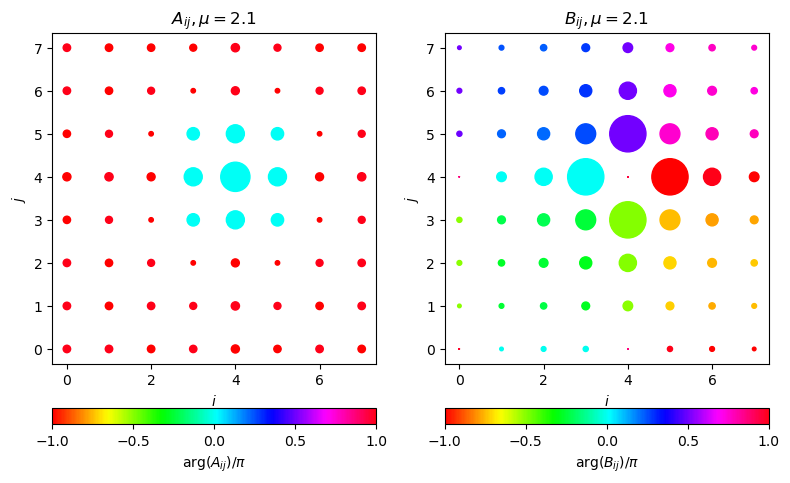

In [217]:
# Plot Wannier Functions and compare to Haining
# mu = 2.1
Lx = 8
Ly = 8
R = (4, 4)
x_vals = np.arange(0, int(Lx), 1) 
y_vals = np.arange(0, int(Ly), 1) 
X, Y = np.meshgrid(x_vals, y_vals)

mu = 2.1
WR_A_LB, WR_B_LB, WR_A_UB, WR_B_UB = Wannier_function(Lx, Ly, mu, R)
# Get magnitudes and phases
#print(WR_A_LB)
WR_A_LB_1 = WR_A_LB[0,:].reshape((Lx, -1)) # first component (sublattice A)
WR_A_LB_1_mag = np.abs(WR_A_LB_1)
#print(WR_A_LB_1_mag)
WR_A_LB_1_phase = np.angle(WR_A_LB_1)
WR_A_LB_2 = WR_A_LB[1,:].reshape((Lx, -1)) # second component (sublattice B)
WR_A_LB_2_mag = np.abs(WR_A_LB_2)
#print(WR_A_LB_2_mag)
WR_A_LB_2_phase = np.angle(WR_A_LB_2)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Subplot for sublattice A
sc1 = axes[0].scatter(X, Y, c = WR_A_LB_1_phase/np.pi, s = WR_A_LB_1_mag*200, cmap='hsv', vmin = -1, vmax = 1)
axes[0].set_title(r"$A_{ij}, \mu = "+str(mu)+"$")
axes[0].set_xlabel(r'$i$')
axes[0].set_ylabel(r'$j$')
cbar0 = plt.colorbar(sc1, ax=axes[0], orientation='horizontal', pad=0.1)
cbar0.set_label(r"arg($A_{ij})/\pi$")

# Subplot for sublattice B
sc2 = axes[1].scatter(X, Y, c = WR_A_LB_2_phase/np.pi, s = WR_A_LB_2_mag*200, cmap='hsv', vmin = -1, vmax = 1)
axes[1].set_title(r"$B_{ij}, \mu = "+str(mu)+"$")
axes[1].set_xlabel(r'$i$')
axes[1].set_ylabel(r'$j$')
cbar1 = plt.colorbar(sc2, ax=axes[1], orientation='horizontal', pad=0.1)
cbar1.set_label(r"arg($B_{ij})/\pi$")
plt.tight_layout()
plt.show()





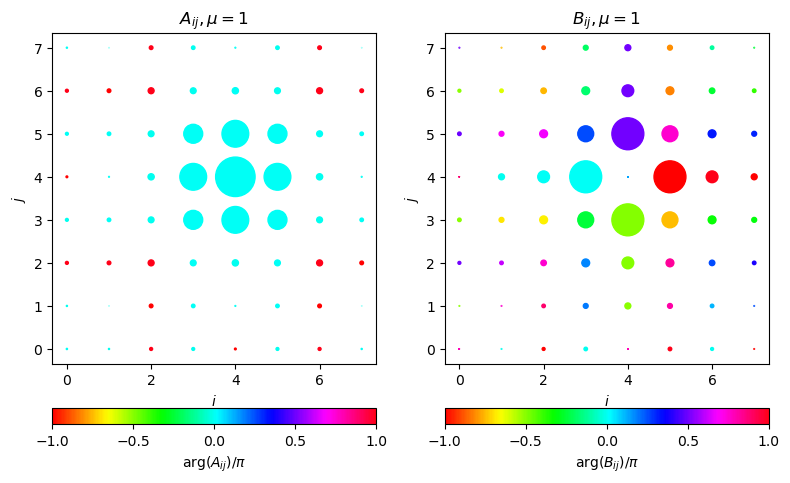

In [218]:
# Plot Wannier Functions and compare to Haining
# mu = 1
Lx = 8
Ly = 8
R = (4, 4)
x_vals = np.arange(0, int(Lx), 1) 
y_vals = np.arange(0, int(Ly), 1) 
X, Y = np.meshgrid(x_vals, y_vals)

mu = 1
(WR_A_LB, WR_B_LB, WR_A_UB, WR_B_UB) = Wannier_function(Lx, Ly, mu, R)
# Get magnitudes and phases
WR_A_LB_1 = WR_A_LB[0,:].reshape((Lx, -1)) # first component (sublattice A)
WR_A_LB_1_mag = np.abs(WR_A_LB_1)
WR_A_LB_1_phase = np.angle(WR_A_LB_1)
WR_A_LB_2 = WR_A_LB[1,:].reshape((Lx, -1)) # second component (sublattice B)
WR_A_LB_2_mag = np.abs(WR_A_LB_2)
WR_A_LB_2_phase = np.angle(WR_A_LB_2)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Subplot for sublattice A
sc1 = axes[0].scatter(X, Y, c = WR_A_LB_1_phase/np.pi, s = WR_A_LB_1_mag*200, cmap='hsv', vmin = -1, vmax = 1)
axes[0].set_title(r"$A_{ij}, \mu = "+str(mu)+"$")
axes[0].set_xlabel(r'$i$')
axes[0].set_ylabel(r'$j$')
cbar0 = plt.colorbar(sc1, ax=axes[0], orientation='horizontal', pad=0.1)
cbar0.set_label(r"arg($A_{ij})/\pi$")

# Subplot for sublattice B
sc2 = axes[1].scatter(X, Y, c = WR_A_LB_2_phase/np.pi, s = WR_A_LB_2_mag*200, cmap='hsv', vmin = -1, vmax = 1)
axes[1].set_title(r"$B_{ij}, \mu = "+str(mu)+"$")
axes[1].set_xlabel(r'$i$')
axes[1].set_ylabel(r'$j$')
cbar1 = plt.colorbar(sc2, ax=axes[1], orientation='horizontal', pad=0.1)
cbar1.set_label(r"arg($B_{ij})/\pi$")
plt.tight_layout()
plt.show()





In [276]:
# Construct function that returns localized, vectorized Lindbladian which acts on single-particle space
def localized_lindbladian(nb, Lx, Ly, mu, R):
    # G is the vectorized input two-point function

    WR_A_LB, WR_B_LB, WR_A_UB, WR_B_UB = Wannier_function(Lx, Ly, mu, R)

    WR_A_LB =  WR_A_LB.reshape(-1, 1, order='F') # index now enumerates over (orbital, x, y). Fortran ordering stacks columns as desired
    WR_B_LB =  WR_B_LB.reshape(-1, 1, order='F')
    WR_A_UB =  WR_A_UB.reshape(-1, 1, order='F')
    WR_B_UB =  WR_B_UB.reshape(-1, 1, order='F')

    # construct (normalized) Wannier projectors
    LB_proj_A = WR_A_LB @ np.conj(WR_A_LB.T)/(Lx*Ly)
    LB_proj_B = WR_B_LB @ np.conj(WR_B_LB.T)/(Lx*Ly)
    UB_proj_A = WR_A_UB @ np.conj(WR_A_UB.T)/(Lx*Ly)
    UB_proj_B = WR_B_UB @ np.conj(WR_B_UB.T)/(Lx*Ly)

    Id = np.eye(LB_proj_A.shape[0])

    # construct vectorized single-particle localized lindbladian
    Lgain = -(nb/2)*(np.kron(np.conj(LB_proj_A + LB_proj_B),Id) + np.kron(Id, LB_proj_A + LB_proj_B))
    Lloss = -(nb/2)*(np.kron(UB_proj_A + UB_proj_B,Id) + np.kron(Id, np.conj(UB_proj_A + UB_proj_B)))
    Ldephasing = (2-nb)*((-1/2)*(np.kron(np.conj(LB_proj_A + LB_proj_B + UB_proj_A + UB_proj_B),Id) + np.kron(Id, LB_proj_A + LB_proj_B + UB_proj_A + UB_proj_B)) + np.kron(np.conj(LB_proj_A), LB_proj_A) + np.kron(np.conj(LB_proj_B), LB_proj_B) + np.kron(np.conj(UB_proj_A),UB_proj_A) + np.kron(np.conj(UB_proj_B),UB_proj_B))

    Ltot = Lgain + Lloss + Ldephasing
    Lsteadystate = nb*(LB_proj_A + LB_proj_B).reshape(-1, 1, order='F')

    return Lsteadystate, Ltot


def Lindbladian_evolution(Lx, Ly, mu, nb=1, history=True, random_init=True, G0=None, tol=1e-3, clear_interval=5):
    """
    Simulates the time evolution of the two-point function under a Lindbladian.
    
    Tracks progress using a loading bar, displays real-time updates, and clears output after a set number of iterations.
    """
    start_time = time.time()  # Track total time

    if history:
        G_history = []
        overlap_history = []

    # Initialize two-point function
    if random_init:
        G_init = random_Cm(Lx * Ly * 2)
    else:
        G_init = G0

    # Compute real-space two-point function for Chern insulator
    G_CI = chern_insulator_Cm(Lx, Ly, mu)

    sp_overlap = np.abs(np.trace(np.conj(G_init.T) @ G_CI))
    if history:
        G_history.append(G_init)
        overlap_history.append(sp_overlap)

    # Create list of positions R
    x_vals = np.arange(int(Lx))
    y_vals = np.arange(int(Ly))
    R_list = list(product(x_vals, y_vals))  # All unit cell positions
    num_R = len(R_list)  # Total number of unit cells

    dt = 1 / (2 * Lx * Ly * 10)
    counter = 0
    G = G_init

    # Outer loop (Epochs)
    while sp_overlap > tol or counter < 100:
        epoch_start_time = time.time()  # Track time for each epoch
        Xtot = np.zeros((np.size(G), np.size(G)), dtype="complex128")  # Accumulate contributions
        Ytot = np.zeros_like(G, dtype="complex128")

        # Track inner loop progress
        inner_counter = 0

        # Inner loop with tqdm progress bar
        with tqdm(R_list, desc=f"Epoch {counter}", leave=True) as progress_bar:
            for R in progress_bar:
                Y, X = localized_lindbladian(nb, Lx, Ly, mu, R)
                Xtot += X
                Ytot += Y

                # Increment and update tqdm progress description
                inner_counter += 1
                if inner_counter % 10 == 0 or inner_counter == num_R:
                    elapsed_inner = time.time() - epoch_start_time
                    progress_bar.set_postfix(inner_progress=f"{inner_counter}/{num_R}", elapsed=f"{elapsed_inner:.2f}s")

        # Update two-point function
        G = G + dt * (Ytot + Xtot @ G)

        # Track history
        if history:
            G_history.append(G)

        sp_overlap = np.abs(np.trace(np.conj(G.T) @ G_CI))
        overlap_history.append(sp_overlap)

        # Print real-time updates only once per epoch
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        tqdm.write(f"Epoch: {counter}, sp_overlap: {sp_overlap:.6f}, Time per epoch: {epoch_time:.2f}s, Total time: {total_time:.2f}s")

        # Clear output every `clear_interval` epochs
        if counter % clear_interval == 0:
            clear_output(wait=True)

        counter += 1

    return G_history, overlap_history

In [278]:
# test
Lx = 4
Ly = 4
mu = 1
G_history, overlap_history = Lindbladian_evolution(Lx, Ly, mu, nb = 1, history = True, random_init = True, G0 = None, tol = 1e-3)

Epoch 16:  75%|███████▌  | 12/16 [00:00<00:00, 19.13it/s]

  Inner Progress: 10/16 (Elapsed: 0.57s)


  Inner Progress: 16/16 (Elapsed: 0.90s)
Epoch: 16, sp_overlap: 8.105863, Time per epoch: 0.90s, Total time: 14.02s


Epoch 17:  75%|███████▌  | 12/16 [00:00<00:00, 18.59it/s]

  Inner Progress: 10/16 (Elapsed: 0.59s)


  Inner Progress: 16/16 (Elapsed: 0.88s)
Epoch: 17, sp_overlap: 8.112338, Time per epoch: 0.88s, Total time: 14.90s


Epoch 18:  75%|███████▌  | 12/16 [00:00<00:00, 19.64it/s]

  Inner Progress: 10/16 (Elapsed: 0.59s)


  Inner Progress: 16/16 (Elapsed: 0.92s)
Epoch: 18, sp_overlap: 8.118889, Time per epoch: 0.93s, Total time: 15.83s


Epoch 19:  69%|██████▉   | 11/16 [00:00<00:00, 15.94it/s]

  Inner Progress: 10/16 (Elapsed: 0.65s)


  Inner Progress: 16/16 (Elapsed: 0.96s)
Epoch: 19, sp_overlap: 8.125515, Time per epoch: 0.97s, Total time: 16.80s


KeyboardInterrupt: 